# Week 5 - Optimization Models for Picking Loans

In [2]:
# Load general utilities
# ----------------------
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.axes as ax
import datetime
import numpy as np
import pickle
import time
import seaborn as sns
import collections

# Load sklearn utilities
# ----------------------
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, brier_score_loss, mean_squared_error, r2_score
from sklearn.metrics import auc, precision_recall_curve, f1_score
from sklearn.calibration import calibration_curve
from sklearn.utils import resample
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Load classifiers
# ----------------
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import LassoLars

# Other Packages
# --------------
from scipy.stats import kendalltau
from sklearn.neural_network import MLPRegressor
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import KMeans
from six import StringIO
from IPython.display import Image
from sklearn.tree import export_graphviz
import pydotplus

# Load debugger, if required
# --------------
pd.options.mode.chained_assignment = None #'warn'

# suppress all warnings
# --------------
import warnings
warnings.filterwarnings("ignore")

## 5.1 Load saved models.
Load the dictionary first, assign value when we need to.

In [3]:
# read saved models
infile = open('week4_saved_models','rb')
saved_models = pickle.load(infile)
infile.close()
print('models loaded:', saved_models.keys())

# save into a new dict if there is anything new to save
models_to_save = saved_models.copy()

models loaded: dict_keys(['reg_lasso1213', 'reg_separate1213', 'l1_logistic1213'])


## 5.2 Build and test baseline investment strategies
Now we test several investment strategies using the learning models above

In [4]:
default_seed = 1
output_file = "output_sample"

In [5]:
# Create a function to print a line to our output file
def dump_to_output(key, value):
    with open(output_file, "a") as f:
        f.write(",".join([str(default_seed), key, str(value)]) + "\n")

In [6]:
def test_investments(data_dict,
                        classifier = None,
                        regressor = None,
                        strategy = 'Random',
                        num_loans = 1000,
                        random_state = default_seed,
                        output_to_file = True):
    '''
    This function tests a variety of investment methodologies and their returns.
    It will run its tests on the loans defined by the test_set element of the data
    dictionary.

    It is currently able to test four strategies
      - random: invest in a random set of loans
      - ranking: score each loan by probability of default, and only invest
                 in the "safest" loans (i.e., those with the lowest probabilities
                 of default)
      - regression: train a single regression model to predict the expected return
                    of loans in the past. Then, for loans we could invest in, simply
                    rank them by their expected returns and invest in that order.
      - two-stage: train two regression models to predict the expected return of
                   defaulted loans and non-defaulted loans in the training set. Then,
                   for each potential loan we could invest in, predict the probability
                   the loan will default, its return if it doesn't default and its
                   return if it does. Then, calculate a weighted combination of
                   the latter using the former to find a predicted return. Rank the
                   loans by this expected return, and invest in that order

    It expects the following parameters
      - data_dict: the dictionary containing both training and testing data;
                   returned by the prepare_data function
      - classifier: a fitted model object which is returned by the fit_classification function.
      - regressor: a fitted model object which is returned by the fit_regression function.
      - strategy: the name of the strategy; one of the three listed above
      - num_loans: the number of loans to be included in the test portfolio
      - num_samples: the number of random samples used to compute average return ()
      - random_state: the random seed to use when selecting a subset of rows
      - output_to_file: if the results will be saved to the output file

    The function returns a dictionary FOR EACH RETURN DEFINITION with the following entries
      - strategy: the name of the strategy
      - average return: the return of the strategy based on the testing set
      - test data: the updated Dataframe of testing data. Useful in the optimization section
    '''

    np.random.seed(random_state)

    # Retrieve the rows that were used to train and test  the
    # classification model
    train_set = data_dict['train_set']
    test_set = data_dict['test_set']

    col_list = ['ret_PESS', 'ret_OPT', 'ret_INTa', 'ret_INTb', 'ret_INTc']

    # Create a dataframe for testing, including the score
    data_test = data.loc[test_set,:]
    out = {}

    for ret_col in col_list:

        if strategy == 'Random':
            # Randomize the order of the rows in the datframe
            data_test = data_test.sample(frac = 1).reset_index(drop = True)

            # Select num_loans to invest in
            pf_test = data_test[['funded_amnt',ret_col]].iloc[:num_loans]

            # Find the average return for these loans
            ret_test = np.dot(pf_test[ret_col],pf_test.funded_amnt)/np.sum(pf_test.funded_amnt)

            # Return
            out[ret_col] = {'strategy':strategy, 'average return':ret_test}

            # Dump the strategy performance to file
            if output_to_file:
                dump_to_output(strategy + "," + ret_col + "::average return", ret_test )

            continue

        elif strategy == 'Regression':

            colname = 'predicted_return_' + ret_col

            data_test[colname] = regressor[ret_col]['predicted_return']

            # Sort the loans by predicted return
            data_test = data_test.sort_values(by=colname, ascending = False).reset_index(drop = True)

            # Pick num_loans loans
            pf_test = data_test[['funded_amnt',ret_col]].iloc[:num_loans]

            # Find their return
            ret_test = np.dot(pf_test[ret_col],pf_test.funded_amnt)/np.sum(pf_test.funded_amnt)

            # Return
            out[ret_col] = {'strategy':strategy, 'average return':ret_test, 'test data':data_test}

            # Dump the strategy performance to file
            if output_to_file:
                dump_to_output(strategy + "," + ret_col + "::average return", ret_test )

            continue

        # Get the predicted scores, if the strategy is not Random or just Regression
        try:
            y_pred_score = classifier['y_pred_probs']
        except:
            y_pred_score = classifier['y_pred_score']

        data_test['score'] = y_pred_score


        if strategy == 'Ranking':
            # Sort the test data by the score
            data_test = data_test.sort_values(by='score').reset_index(drop = True)

            # Select num_loans to invest in
            pf_test = data_test[['funded_amnt',ret_col]].iloc[:num_loans]

            # Find the average return for these loans
            ret_test = np.dot(pf_test[ret_col],pf_test.funded_amnt)/np.sum(pf_test.funded_amnt)

            # Return
            out[ret_col] = {'strategy':strategy, 'average return':ret_test}

            # Dump the strategy performance to file
            if output_to_file:
                dump_to_output(strategy + "," + ret_col + "::average return", ret_test )

            continue


        elif strategy == 'Two-stage':

            # Load the predicted returns
            data_test['predicted_regular_return'] = regressor[ret_col]['predicted_regular_return']
            data_test['predicted_default_return'] = regressor[ret_col]['predicted_default_return']

            # Compute expectation
            colname = 'predicted_return_' + ret_col

            data_test[colname] = ( (1-data_test.score)*data_test.predicted_regular_return +
                                             data_test.score*data_test.predicted_default_return )

            # Sort the loans by predicted return
            data_test = data_test.sort_values(by=colname, ascending = False).reset_index(drop = True)

            # Pick num_loans loans
            pf_test = data_test[['funded_amnt',ret_col]].iloc[:num_loans]

            # Find their return
            ret_test = np.dot(pf_test[ret_col],pf_test.funded_amnt)/np.sum(pf_test.funded_amnt)

            # Return
            out[ret_col] = {'strategy':strategy, 'average return':ret_test, 'test data':data_test}

            # Dump the strategy performance to file
            if output_to_file:
                dump_to_output(strategy + "," + ret_col + "::average return", ret_test )

            continue

        elif strategy == 'Crystal-ball':

            # Sort the loans by realized return
            data_test = data_test.sort_values(by=ret_col, ascending = False).reset_index(drop = True)

            # Pick num_loans loans
            pf_test = data_test[['funded_amnt',ret_col]].iloc[:num_loans]

            # Find their return
            ret_test = np.dot(pf_test[ret_col],pf_test.funded_amnt)/np.sum(pf_test.funded_amnt)

            # Return
            out[ret_col] = {'strategy':strategy, 'average return':ret_test}

            # Dump the strategy performance to file
            if output_to_file:
                dump_to_output(strategy + "," + ret_col + "::average return", ret_test )

            continue

        elif strategy == 'KMeans':
            
            # Extract unique kmeans values
            kmeans_values = data_test['kmeans'].unique()

            for kmean_val in kmeans_values:

                # Subset data based on current kmean value
                data_subset = data_test[data_test['kmeans'] == kmean_val].copy()

                # Reset the index of the subset for direct indexing
                data_subset.reset_index(drop=True, inplace=True)

                # Filter the predicted returns to match the data_subset length
                predicted_regular_return_subset = regressor[ret_col]['predicted_regular_return'][data_subset.index]
                predicted_default_return_subset = regressor[ret_col]['predicted_default_return'][data_subset.index]

                # Load the predicted returns
                data_subset['predicted_regular_return'] = predicted_regular_return_subset
                data_subset['predicted_default_return'] = predicted_default_return_subset

                # Compute expectation
                colname = 'predicted_return_' + ret_col

                data_subset[colname] = ((1-data_subset.score) * data_subset.predicted_regular_return +
                                        data_subset.score * data_subset.predicted_default_return)

                # Sort the loans by predicted return
                data_subset = data_subset.sort_values(by=colname, ascending = False).reset_index(drop = True)

                # Pick num_loans loans
                pf_test = data_subset[['funded_amnt',ret_col]].iloc[:num_loans]

                # Find their return
                ret_test = np.dot(pf_test[ret_col],pf_test.funded_amnt)/np.sum(pf_test.funded_amnt)

                # Return
                out_key = ret_col + "_kmean_" + str(kmean_val)  # Use a unique key for each kmean value
                out[out_key] = {'strategy':strategy, 'kmean':kmean_val, 'average return':ret_test, 'test data':data_subset}

                # Dump the strategy performance to file
                if output_to_file:
                    dump_to_output(strategy + "," + ret_col + "_kmean_" + str(kmean_val) + "::average return", ret_test)

            continue

        else:
            return 'Not a valid strategy'

    return out

In [10]:
# 1. Load the data and engineer the features
## 1.1 Load data

# Read the data and features from the pickle
data, discrete_features, continuous_features, ret_cols = pickle.load( open("C:\\Users\\rodol\\OneDrive\\Documents\\Training\\Carnegie_Mellon_University\\Courses\\Mini_7\\Business_Value_Analytics\\General\\WK2\\PickleData\\ret_data_selection.pickle", "rb") )

# Create the outcome
data["outcome"] = data.loan_status.isin(["Charged Off", "Default"])

# Create a feature for the length of a person's credit history at the
# time the loan is issued
data['cr_hist'] = (data.issue_d - data.earliest_cr_line) / np.timedelta64(1, 'M')
continuous_features.append('cr_hist')

# Randomly assign each row to a training and test set. We do this now
# because we will be fitting a variety of models on various time periods,
# and we would like every period to use the *same* training/test split
np.random.seed(default_seed)
data['train'] = np.random.choice([True, False], size = len(data), p = [0.7, 0.3])

In [12]:
data.head()

,id,loan_amnt,funded_amnt,term,int_rate,grade,emp_length,home_ownership,annual_inc,verification_status,...,loan_length,term_num,ret_PESS,ret_OPT,ret_INTa,ret_INTb,ret_INTc,outcome,cr_hist,train
6,10179520,3000.0,3000.0,36 months,12.85,B,10+ years,RENT,25000.0,Verified,...,6.965235,36,0.020172,0.104260,0.024318,0.043948,0.080483,False,271.052794,True
7,10139658,12000.0,12000.0,36 months,13.53,B,10+ years,RENT,40000.0,Source Verified,...,20.994271,36,0.037772,0.064769,0.033844,0.051672,0.084439,False,182.016058,False
10,10148122,12000.0,12000.0,36 months,7.62,A,3 years,MORTGAGE,96500.0,Not Verified,...,29.996509,36,0.038821,0.046590,0.033457,0.049593,0.079043,False,123.008686,True
14,10224583,11100.0,11100.0,36 months,14.98,C,10+ years,MORTGAGE,90000.0,Not Verified,...,26.021068,36,0.074344,0.102854,0.056247,0.074762,0.108653,False,150.015401,True
15,10149566,8000.0,8000.0,36 months,10.99,B,2 years,MORTGAGE,33000.0,Not Verified,...,21.979917,36,-0.099091,-0.099091,-0.052643,-0.041801,-0.021930,True,269.048646,True


In [13]:
data_kmeans = data.copy()
data_kmeans['loan_status_binary'] = data_kmeans['outcome'].apply(lambda x: 1 if x == True else 0)
continuous_features_kmeans = continuous_features.copy()
continuous_features_kmeans.append('loan_status_binary')
data_kmeans = data_kmeans[['int_rate', 'annual_inc','loan_amnt', 'dti','inq_last_6mths', 'open_acc', 'total_pymnt']]

In [14]:
df_st =  StandardScaler().fit_transform(data_kmeans) # this is an array

# see few rows of standardized dataset
pd.DataFrame(df_st, columns=data_kmeans.columns).head()

,int_rate,annual_inc,loan_amnt,dti,inq_last_6mths,open_acc,total_pymnt
0,-0.295088,-1.326972,-1.389471,0.947673,-0.810225,-1.363043,-1.196201
1,-0.138737,-0.876429,-0.233459,-0.050791,-0.810225,-0.912115,-0.070260
2,-1.497616,0.820617,-0.233459,-0.609364,-0.810225,1.342527,-0.066082
3,0.194660,0.625382,-0.349060,-1.754889,-0.810225,-0.461186,-0.046380
4,-0.722756,-1.086682,-0.747242,-0.204302,0.200414,-0.461186,-0.926253


In [15]:
K=3
kmeans = KMeans(n_clusters=K, random_state=10).fit(df_st)
labels = kmeans.labels_
collections.Counter(labels) # show the number of occurences of each of the labels

Counter({0: 80714, 1: 53432, 2: 70857})

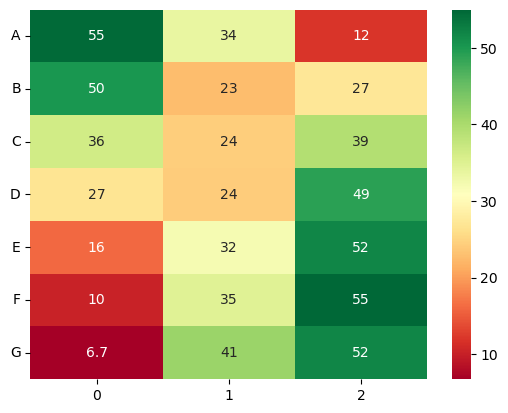

In [16]:
grade =  data.grade.to_numpy() # np_array
K=3
ltr2num = {'A':0, 'B':1, 'C':2, 'D':3, 'E':4, 'F':5, 'G':6}
table = np.zeros([7,K]) # row = letter grade, column = kmeans label
for j in range(df_st.shape[0]):
    table[ltr2num[grade[j]], labels[j]]+=1 # confusion matrix
for i in range(7):
    table[i,:] = np.round(table[i,:]*100/table[i,:].sum(), 1)

df_temp = pd.DataFrame(table, columns = [0,1,2])
# visulaize confusion matrix using heatmap
grades = ['A', 'B', 'C', 'D', 'E', 'F', 'G']
sns.heatmap(df_temp, annot=True, cmap='RdYlGn',  yticklabels=grades)
plt.yticks(rotation=0, ha='right')  # ha is the horizontal alignment
plt.show()

In [17]:
data['kmeans'] = labels

In [18]:
discrete_features.remove('grade')

In [19]:
#Continuous
features_to_remove = ['funded_amnt'] #I cannot be removed until now
continuous_features = [feature for feature in continuous_features if feature not in features_to_remove]

In [20]:
columns_to_remove = ['home_ownership_RENT', 'purpose_credit_card', 'purpose_house', 'home_ownership_OTHER', 'cr_hist', 'verification_status_Verified']

## Up to here I added to match previous code

In [21]:
# Create a matrix of features and outcomes, with dummies. Record the
# names of the dummies for later use
X_continuous = data[continuous_features].values

X_discrete = pd.get_dummies(data[discrete_features], dummy_na = True, prefix_sep = "::", drop_first = True)
discrete_features_dummies = X_discrete.columns.tolist()
X_discrete = X_discrete.values

X = np.concatenate( (X_continuous, X_discrete), axis = 1 )

y = data.outcome.values

train = data.train.values

<AxesSubplot:>

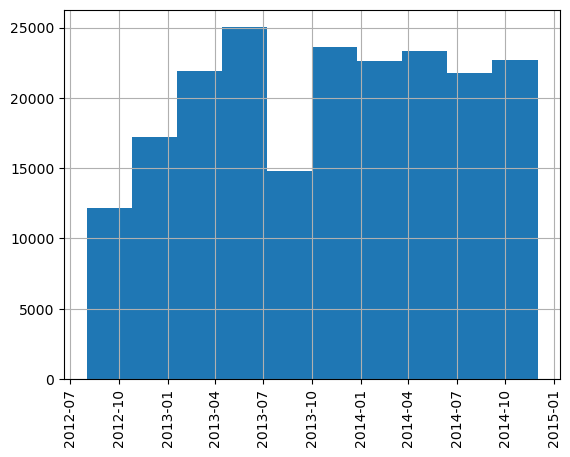

In [22]:
# take a look at distribution in date to decide 
# the size of train and test set splitted by time

data['issue_d'].hist(xrot=90)

In [23]:
# fund out cut off date to divide the data into ~70% traininig data and ~30% testing data
date_threshold = np.quantile(data['issue_d'],5/7)

In [24]:
## 1.2 Prepare functions to fit and evaluate models

def prepare_data(data_subset = np.array([True]*len(data)),
                    n_samples_train = 20000,
                    n_samples_test = 10000,
                    feature_subset = None,
                    date_range_train = (data.issue_d.min(), date_threshold),
                    date_range_test = (date_threshold, data.issue_d.max()),
                    random_state = default_seed):
    '''
    This function will prepare the data for classification or regression.
    It expects the following parameters:
      - data_subset: a numpy array with as many entries as rows in the
                     dataset. Each entry should be True if that row
                     should be used, or False if it should be ignored
      - n_samples_train: the total number of samples to be used for training.
                         Will trigger an error if this number is larger than
                         the number of rows available after all filters have
                         been applied
      - n_samples_test: as above for testing
      - feature_subect: A list containing the names of the features to be
                        used in the model. In None, all features in X are
                        used
      - date_range_train: a tuple containing two dates. All rows with loans
                          issued outside of these two dates will be ignored in
                          training
      - date_range_test: as above for testing
      - random_state: the random seed to use when selecting a subset of rows
      
    Note that this function assumes the data has a "Train" column, and will
    select all training rows from the rows with "True" in that column, and all
    the testing rows from those with a "False" in that column.
    
    This function returns a dictionary with the following entries
      - X_train: the matrix of training data
      - y_train: the array of training labels
      - train_set: a Boolean vector with as many entries as rows in the data
                  that denotes the rows that were used in the train set
      - X_test: the matrix of testing data
      - y_test: the array of testing labels
      - test_set: a Boolean vector with as many entries as rows in the data
                  that denotes the rows that were used in the test set
    '''
    
    np.random.seed(random_state)
        
    # Filter down the data to the required date range, and downsample
    # as required
    filter_train = ( train & (data.issue_d >= date_range_train[0]) &
                            (data.issue_d <= date_range_train[1]) & data_subset ).values
    filter_test = ( (train == False) & (data.issue_d >= date_range_test[0])
                            & (data.issue_d <= date_range_test[1]) & data_subset ).values
    
    filter_train[ np.random.choice( np.where(filter_train)[0], size = filter_train.sum() 
                                   - n_samples_train, replace = False ) ] = False
    filter_test[ np.random.choice( np.where(filter_test)[0], size = filter_test.sum() 
                                   - n_samples_test, replace = False ) ] = False
    
    # Prepare the training and test set
    X_train = X[ filter_train , :]
    X_test = X[ filter_test, :]
    if feature_subset != None:
        cols = [i for i, j in enumerate(continuous_features + discrete_features_dummies)
                                                     if j.split("::")[0] in feature_subset]
        X_train = X_train[ : , cols ]
        X_test = X_test[ : , cols ]
        
    y_train = y[ filter_train ]
    y_test = y[ filter_test ]
    
    # Scale the variables
    scaler = preprocessing.MinMaxScaler()

    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    # return training and testing data
    out = {'X_train':X_train, 'y_train':y_train, 'train_set':filter_train, 
           'X_test':X_test, 'y_test':y_test, 'test_set':filter_test}
    
    return out

## Implement the test strategies on 2012-13 data

In [25]:
## read saved models
reg_rf1213 = saved_models['reg_lasso1213']
rf1213 = saved_models['l1_logistic1213']

In [30]:
# Read the data and features from the pickle
data, discrete_features, continuous_features, ret_cols = pickle.load( open("C:\\Users\\rodol\\OneDrive\\Documents\\Training\\Carnegie_Mellon_University\\Courses\\Mini_7\\Business_Value_Analytics\\General\\WK2\\PickleData\\ret_data_selection.pickle", "rb" ) )

In [31]:
final_features = [i for i in discrete_features + continuous_features]

In [32]:
data_dict = prepare_data(feature_subset = final_features)

In [33]:
all_features = pd.Series(continuous_features + discrete_features_dummies)
idx = [i for i, j in enumerate(continuous_features + discrete_features_dummies)
                                                     if j.split("::")[0] in final_features]
selected_features = all_features[idx]
selected_features.reset_index(drop=True,inplace=True)

### 5.2.1 Random

In [35]:
col_list = ['ret_PESS', 'ret_OPT', 'ret_INTa', 'ret_INTb', 'ret_INTc']
test_strategy = 'Random'

print('strategy:',test_strategy)   
strat_random = test_investments(data_dict,strategy = test_strategy, 
                            num_loans = 100, output_to_file = False, random_state = 1)
for ret_col in col_list:
    print(ret_col + ': ' + str(strat_random[ret_col]['average return']))

strategy: Random
ret_PESS: -0.025932803119014153
ret_OPT: 0.05713320134737589
ret_INTa: -0.000767943755866553
ret_INTb: 0.018568694191229865
ret_INTc: 0.06435550993684734


### 5.2.2 Ranking

In [36]:
test_strategy = 'Ranking'

print('strategy:',test_strategy)
strat_rank = test_investments(data_dict, classifier=rf1213, strategy = test_strategy, 
                        num_loans = 100, output_to_file = False)

for ret_col in col_list:
    print(ret_col + ': ' + str(strat_rank[ret_col]['average return']))

strategy: Ranking
ret_PESS: -0.03046761908912588
ret_OPT: 0.07201061469864113
ret_INTa: -0.013334348197348791
ret_INTb: 0.018743150713888115
ret_INTc: 0.04046207839222519


### 5.2.3 Regression

In [37]:
test_strategy = 'Regression'

print('strategy:',test_strategy)
strat_reg = test_investments(data_dict, regressor=reg_rf1213, strategy = test_strategy, 
                        num_loans = 100)
for ret_col in col_list:
    print(ret_col + ': ' + str(strat_reg[ret_col]['average return']))

strategy: Regression
ret_PESS: -0.016901597548704447
ret_OPT: 0.057949057961057183
ret_INTa: 0.00019579424559803814
ret_INTb: 0.009686694721834983
ret_INTc: 0.041335768868932934


### 5.2.4 Two-stage
#### Compute random forest regression:

In [38]:
## load model
reg_rf_separate1213 = saved_models['reg_separate1213']

#### Test two-stage stratgy

In [39]:
test_strategy = 'Two-stage'


print('strategy:',test_strategy)
two_stage = test_investments(data_dict, classifier = rf1213, regressor = reg_rf_separate1213, 
                             strategy = test_strategy, num_loans = 100)

for ret_col in col_list:
    print(ret_col + ': ' + str(two_stage[ret_col]['average return']))

strategy: Two-stage
ret_PESS: -0.027007802196406784
ret_OPT: 0.08237446140509934
ret_INTa: -0.0030446628515368116
ret_INTb: 0.011932646492797861
ret_INTc: 0.044678269513936365


### New KMeans Model

In [41]:
# test_strategy = 'KMeans'

# print('strategy:', test_strategy)
# kmeans_strategy = test_investments(data_dict, classifier = rf1213, regressor = reg_rf_separate1213, 
#                              strategy = test_strategy, num_loans = 100)

# NEW PART OF THE ANALYSIS

## 5.3 Optimization
 In this section, we implement three different optimization models. To illustrate and compare these models we will only use the M1-PESS definition and the predicted returns from the previously tested two-stage strategy.

## Three optimization models to picks loans

### 5.3.1 Directly maximize total profit


In [3]:
# !python -m pip install gurobipy

     ---------------------------------------- 9.7/9.7 MB 6.1 MB/s eta 0:00:00


In [32]:
# import os

# os.environ["GRB_LICENSE_FILE"] = r"C:\Users\rodol\OneDrive\Documents\Training\Carnegie_Mellon_University\Courses\Mini_7\Business_Value_Analytics\General\WK5\Data\gurobi.lic"

In [42]:
import gurobipy as gp
from gurobipy import GRB

ret_col = 'ret_PESS'
test_pool = two_stage[ret_col]['test data']
num_var = test_pool.shape[0]
num_loans = 10

## first define cost vector
c = np.zeros(num_var) # cost vector
for i in range(num_var):
    c[i] = test_pool['predicted_return_'+ret_col].iloc[i]*test_pool.funded_amnt.iloc[i]

## then define vector of all ones
u = np.zeros(num_var) # cost vector
for i in range(num_var):
    u[i] = 1
    

# please open your free trial, downlaod the license, and get the WLS parameters. 
# https://www.gurobi.com/free-trial/
# If you are using a client license for a floating site token server, Gurobi Instant Cloud, 
# WLS (Web License Service), or a Compute Server/Cluster Manager, you may have chosen to 
# pass the credentials via parameters to the Gurobi environment such as follows
env = gp.Env(empty=True)
env.setParam('WLSACCESSID', '9f11ef5f-f6b2-424f-b878-41f86258c5da')
env.setParam('WLSSECRET', 'd898d09a-1223-4a71-931b-8800234f87c1')
env.setParam('LICENSEID', 2415696)
env.start()

with gp.Model(env=env) as model:
# Placing the variables in a pandas Series object will allow us to use the dot() function
    x = pd.Series(model.addVars(num_var,vtype=GRB.BINARY))

    model.setObjective(c.dot(x), GRB.MAXIMIZE)

    model.addConstr(u.dot(x) <= num_loans)

    # Formulate problem
    model.optimize()
    
    # Extracting the optimal solution and optimal value
    print('Optimal expected return:',model.ObjVal)
    for i in range(num_var):
        if x[i].X > 0: # most variables are zero, so we just print the non-zero variables
            print('Choose loan',i+1)    

Set parameter Username
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2415696
Academic license - for non-commercial use only - registered to xiaohanf@andrew.cmu.edu
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Academic license - for non-commercial use only - registered to xiaohanf@andrew.cmu.edu
Optimize a model with 1 rows, 10000 columns and 10000 nonzeros
Model fingerprint: 0xa9121785
Variable types: 0 continuous, 10000 integer (10000 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e-03, 5e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+01, 1e+01]
Found heuristic solution: objective 3169.5157611
Presolve removed 1 rows and 10000 columns
Presolve time: 0.01s
Presolve: All rows and columns removed

Explored 0 node

### Partial Investments
Now we want to decide which loan to invest in, and how much should the investment be.

In [43]:
import gurobipy as gp
from gurobipy import GRB

ret_col = 'ret_PESS'
test_pool = two_stage[ret_col]['test data']
num_var = test_pool.shape[0]
num_loans = 10
min_investment = 100

# Define cost vector
c = np.zeros(num_var)
for i in range(num_var):
    c[i] = test_pool['predicted_return_'+ret_col].iloc[i]*test_pool.funded_amnt.iloc[i]

# Define vector of all ones
u = np.zeros(num_var)
for i in range(num_var):
    u[i] = 1
    
# please open your free trial, downlaod the license, and get the WLS parameters. 
# https://www.gurobi.com/free-trial/
# If you are using a client license for a floating site token server, Gurobi Instant Cloud, 
# WLS (Web License Service), or a Compute Server/Cluster Manager, you may have chosen to 
# pass the credentials via parameters to the Gurobi environment such as follows
env = gp.Env(empty=True)
env.setParam('WLSACCESSID', '9f11ef5f-f6b2-424f-b878-41f86258c5da')
env.setParam('WLSSECRET', 'd898d09a-1223-4a71-931b-8800234f87c1')
env.setParam('LICENSEID', 2415696)
env.start()

with gp.Model(env=env) as model:

    # Define the binary variables x and continuous variables y
    x = pd.Series(model.addVars(num_var, vtype=GRB.BINARY))
    y = pd.Series(model.addVars(num_var, lb=0, ub=test_pool.funded_amnt.values))

    # Set the objective function
    model.setObjective(c.dot(y), GRB.MAXIMIZE)

    # Add constraints
    for i in range(num_var):
        model.addConstr(y[i] <= x[i] * test_pool.funded_amnt.iloc[i])
        model.addConstr(y[i] >= min_investment * x[i])

    # Update the budget constraint to be based on the sum of y
    model.addConstr(u.dot(y) <= num_loans * test_pool.funded_amnt.mean()) # Adjust the budget constraint as needed

    model.optimize()

    # Extracting the optimal solution and optimal value
    print('Optimal expected return:', model.ObjVal)
    for i in range(num_var):
        if x[i].X > 0:
            print('Choose loan', i+1, 'with investment amount:', y[i].X)


Set parameter Username
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2415696
Academic license - for non-commercial use only - registered to xiaohanf@andrew.cmu.edu
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Academic license - for non-commercial use only - registered to xiaohanf@andrew.cmu.edu
Optimize a model with 20001 rows, 20000 columns and 50000 nonzeros
Model fingerprint: 0x93003de6
Variable types: 10000 continuous, 10000 integer (10000 binary)
Coefficient statistics:
  Matrix range     [1e+00, 4e+04]
  Objective range  [2e-03, 5e+03]
  Bounds range     [1e+00, 4e+04]
  RHS range        [1e+05, 1e+05]
Found heuristic solution: objective -0.0000000
Presolve removed 18368 rows and 18368 columns
Presolve time: 0.05s
Presolved: 1633 rows, 1632 columns, 4080 nonz

### 5.3.2: Maximize profit with budget constraint

In [44]:
ret_col = 'ret_PESS'
test_pool = two_stage[ret_col]['test data']
num_var = test_pool.shape[0]
num_loans = 100
Budget = 1000000

## first define cost vector
c = np.zeros(num_var) # cost vector
for i in range(num_var):
    c[i] = test_pool['predicted_return_'+ret_col].iloc[i]*test_pool.funded_amnt.iloc[i]

## then define vector of all ones
u = np.zeros(num_var) # cost vector
for i in range(num_var):
    u[i] = 1
    
# please open your free trial, downlaod the license, and get the WLS parameters. 
# https://www.gurobi.com/free-trial/
# If you are using a client license for a floating site token server, Gurobi Instant Cloud, 
# WLS (Web License Service), or a Compute Server/Cluster Manager, you may have chosen to 
# pass the credentials via parameters to the Gurobi environment such as follows
env = gp.Env(empty=True)
env.setParam('WLSACCESSID', '9f11ef5f-f6b2-424f-b878-41f86258c5da')
env.setParam('WLSSECRET', 'd898d09a-1223-4a71-931b-8800234f87c1')
env.setParam('LICENSEID', 2415696)
env.start()

with gp.Model(env=env) as model:

    # Placing the variables in a pandas Series object will allow us to use the dot() function
    x = pd.Series(model.addVars(num_var,vtype=GRB.BINARY))
    amt = pd.Series(test_pool[0:num_var].loan_amnt)

    model.setObjective(c.dot(x), GRB.MAXIMIZE)

    model.addConstr(u.dot(x) <= num_loans)
    model.addConstr(u.dot(x) >= 0.9*num_loans)
    model.addConstr(amt.dot(x) <= Budget)

    model.optimize()    
    
    # Extracting the optimal solution and optimal value
    print('Optimal expected return:',model.ObjVal)
    for i in range(num_var):
        if x[i].X > 0: # most variables are zero, so we just print the non-zero variables
            print('Choose loan',i+1) 
    
    opt_sln_IP2 = np.zeros(num_var)
    for i in range(num_var):
        opt_sln_IP2[i] = x[i].X
    
    print(sum(opt_sln_IP2))


Set parameter Username
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2415696
Academic license - for non-commercial use only - registered to xiaohanf@andrew.cmu.edu
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Academic license - for non-commercial use only - registered to xiaohanf@andrew.cmu.edu
Optimize a model with 3 rows, 10000 columns and 30000 nonzeros
Model fingerprint: 0x820573a2
Variable types: 0 continuous, 10000 integer (10000 binary)
Coefficient statistics:
  Matrix range     [1e+00, 4e+04]
  Objective range  [2e-03, 5e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e+01, 1e+06]
Presolve time: 0.02s
Presolved: 3 rows, 10000 columns, 30000 nonzeros
Variable types: 0 continuous, 10000 integer (10000 binary)
Found heuristic solution: objective 11

### Sanity check
Intuitively the optimal solution $x^*$ should sequentially choose the highest return loans. We compare $x^*$ with opt_sln below.

In [45]:
temp = np.sort(c)
temp = temp[::-1] # in descending order
cutoff = temp[100]
y = np.zeros(num_var)
for i in range(num_var):
    if cutoff<c[i]:
        y[i]=1
print("number of entries that differ:", int((y-opt_sln_IP2).sum()) )

number of entries that differ: 10


### 5.3.3: Maximize profit with risk-return tradeoff

In [46]:
## First we need to train a clustering model to estimate the variance of return
n_clusters = 50
train_set = data_dict['train_set']
data_train = data.loc[train_set,:]

# Create a dataframe for testing, including the score
data_test = two_stage[ret_col]['test data']

kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(data_dict['X_train'])
data_train['clusID'] = kmeans.predict(data_dict['X_train'])
data_test['clusID'] = kmeans.predict(data_dict['X_test'])
data_test['volatility'] = 0

for idx in range(n_clusters):
    std_clus = np.std(data_train[ret_col][data_train.clusID == idx])
    data_test.volatility[data_test.clusID == idx] = std_clus

## Specify the parameters of the optimization model
# beta: penalty factor on the risk
beta = 0.9
#Budget = 10.7*1000000

In [47]:
ret_col = 'ret_PESS'
test_pool = two_stage[ret_col]['test data']
num_var = test_pool.shape[0]
num_loans = 100
Budget = 1000000

## define objective
c = np.zeros(num_var) # cost vector
for i in range(num_var):
    c[i] = (test_pool['predicted_return_'+  ret_col].iloc[i] -
            beta * test_pool.volatility.iloc[i]) * test_pool.loan_amnt.iloc[i]
    
## then define vector of all ones
u = np.zeros(num_var) # cost vector
for i in range(num_var):
    u[i] = 1
    
# please open your free trial, downlaod the license, and get the WLS parameters. 
# https://www.gurobi.com/free-trial/
# If you are using a client license for a floating site token server, Gurobi Instant Cloud, 
# WLS (Web License Service), or a Compute Server/Cluster Manager, you may have chosen to 
# pass the credentials via parameters to the Gurobi environment such as follows
env = gp.Env(empty=True)
env.setParam('WLSACCESSID', '9f11ef5f-f6b2-424f-b878-41f86258c5da')
env.setParam('WLSSECRET', 'd898d09a-1223-4a71-931b-8800234f87c1')
env.setParam('LICENSEID', 2415696)
env.start()

with gp.Model(env=env) as model:

    # Placing the variables in a pandas Series object will allow us to use the dot() function
    x = pd.Series(model.addVars(num_var,vtype=GRB.BINARY))
    amt = pd.Series(test_pool[0:num_var].loan_amnt)

    model.setObjective(c.dot(x), GRB.MAXIMIZE)

    model.addConstr(u.dot(x) <= num_loans)
    model.addConstr(u.dot(x) >= 0.9*num_loans)
    model.addConstr(amt.dot(x) <= Budget)

    model.optimize()    
    
    # Extracting the optimal solution and optimal value
    print('Optimal expected return:',model.ObjVal)
    for i in range(num_var):
        if x[i].X > 0: # most variables are zero, so we just print the non-zero variables
            print('Choose loan',i+1)  
    
    opt_sln_IP3 = np.zeros(num_var)
    for i in range(num_var):
        opt_sln_IP3[i] = x[i].X
    
    print(sum(opt_sln_IP3))

Set parameter Username
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2415696
Academic license - for non-commercial use only - registered to xiaohanf@andrew.cmu.edu
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Academic license - for non-commercial use only - registered to xiaohanf@andrew.cmu.edu
Optimize a model with 3 rows, 10000 columns and 30000 nonzeros
Model fingerprint: 0x8d107bb3
Variable types: 0 continuous, 10000 integer (10000 binary)
Coefficient statistics:
  Matrix range     [1e+00, 4e+04]
  Objective range  [6e+01, 8e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e+01, 1e+06]
Presolve time: 0.02s
Presolved: 3 rows, 10000 columns, 30000 nonzeros
Variable types: 0 continuous, 10000 integer (10000 binary)
Found heuristic solution: objective -1

### 5.3.4 Visualization: violin plots for the expected returns of the above strategies

In [48]:
test_pool['label'] = ['test_pool']*test_pool.shape[0]

# now we create a df for OPT of IP2
test_pool['chosen_IP2'] = opt_sln_IP2
df2 = test_pool[test_pool.chosen_IP2 == 1].copy() # df containing only rows chosen by IP2
test_pool = test_pool.drop(columns=['chosen_IP2']) # drop this columns in order to append
df2 = df2.drop(columns=['chosen_IP2']) # drop this columns in order to append
df2['label'] = ['IP2']*df2.shape[0]

# create a df for OPT of IP3
test_pool['chosen_IP3'] = opt_sln_IP3
df3 = test_pool[test_pool.chosen_IP3 == 1].copy() # df containing only rows chosen by IP3
test_pool = test_pool.drop(columns=['chosen_IP3']) # drop this columns in order to append
df3 = df3.drop(columns=['chosen_IP3']) # drop this columns in order to append
df3['label'] = ['IP3']*df3.shape[0]

# concatenate the dataframes
df_big = test_pool.append([df2,df3])

Text(0, 0.5, 'ret_PESS')

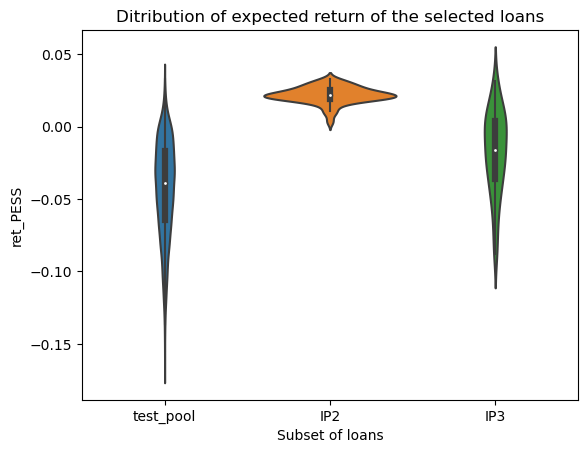

In [49]:
ax = sns.violinplot(y=df_big["predicted_return_ret_PESS"], x=df_big["label"], 
                    data=df_big, order=['test_pool','IP2','IP3'])
ax.set_title("Ditribution of expected return of the selected loans")
ax.set_xlabel("Subset of loans")
ax.set_ylabel("ret_PESS")

## 5.4. Sensitivity analysis of the optimization solution by varying the budgets and the number of loans invested in
Build a trade-off curve between the beta value and the optimization objective (expected return). For this we loop through various values of beta from 0.1 through some large number in steps of 0.1 say. Then we create a plot of different pairs of means and stdevns of the expected return of the portfolios as you vary beta. The two axes will then be mean (return) and stdevn (risk).

In [50]:
num_var = test_pool.shape[0]
Budget = 1000000
beta_min = 0.1
step = 0.1
num_beta = 10
u = np.zeros(num_var) # units vector

for i in range(num_var):
    u[i] = 1

amt = pd.Series(test_pool[0:num_var].loan_amnt)

table = np.zeros([num_beta,2]) # store the return and risk

env = gp.Env(empty=True)
env.setParam('WLSACCESSID', '9f11ef5f-f6b2-424f-b878-41f86258c5da')
env.setParam('WLSSECRET', 'd898d09a-1223-4a71-931b-8800234f87c1')
env.setParam('LICENSEID', 2415696)
env.start()

for j in range(num_beta):
    beta = beta_min + j*step
    
    c = np.zeros(num_var) # cost vector
    for i in range(num_var):
        c[i] = (test_pool['predicted_return_'+  ret_col].iloc[i] - beta * test_pool.volatility.iloc[i]) * test_pool.loan_amnt.iloc[i]
    
    with gp.Model(env=env) as model:

        x = pd.Series(model.addVars(num_var,vtype=GRB.BINARY))

        model.setObjective(c.dot(x), GRB.MAXIMIZE)
    
        model.addConstr(u.dot(x) <= num_loans)
        model.addConstr(u.dot(x) >= 0.9*num_loans)
        model.addConstr(amt.dot(x) <= Budget)

        model.optimize() 
    
        opt = np.zeros(num_var)
        for k in range(num_var):
            opt[k] = x[k].X
        test_pool['chosen'] = opt
        df = test_pool[test_pool.chosen == 1]
        table[j,0] = df['predicted_return_'+  ret_col].sum()
        table[j,1] = df.volatility.sum()

Set parameter Username
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2415696
Academic license - for non-commercial use only - registered to xiaohanf@andrew.cmu.edu
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Academic license - for non-commercial use only - registered to xiaohanf@andrew.cmu.edu
Optimize a model with 3 rows, 10000 columns and 30000 nonzeros
Model fingerprint: 0xfd6b2b80
Variable types: 0 continuous, 10000 integer (10000 binary)
Coefficient statistics:
  Matrix range     [1e+00, 4e+04]
  Objective range  [6e-01, 5e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e+01, 1e+06]
Presolve time: 0.03s
Presolved: 3 rows, 10000 columns, 30000 nonzeros
Variable types: 0 continuous, 10000 integer (10000 binary)
Found heuristic solution: objective 86


Explored 1 nodes (1 simplex iterations) in 0.07 seconds (0.04 work units)
Thread count was 8 (of 8 available processors)

Solution count 2: -6542.34 -6559.33 
No other solutions better than -6542.34

Optimal solution found (tolerance 1.00e-04)
Best objective -6.542341478341e+03, best bound -6.542341478341e+03, gap 0.0000%
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Academic license - for non-commercial use only - registered to xiaohanf@andrew.cmu.edu
Optimize a model with 3 rows, 10000 columns and 30000 nonzeros
Model fingerprint: 0x5bffed10
Variable types: 0 continuous, 10000 integer (10000 binary)
Coefficient statistics:
  Matrix range     [1e+00, 4e+04]
  Objective range  [4e+01, 7e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e+01, 1e+06]
Presolve time: 0.02s
Presolved: 3 rows, 100

### Visualization: Return vs Risk curve

Text(0, 0.5, 'risk')

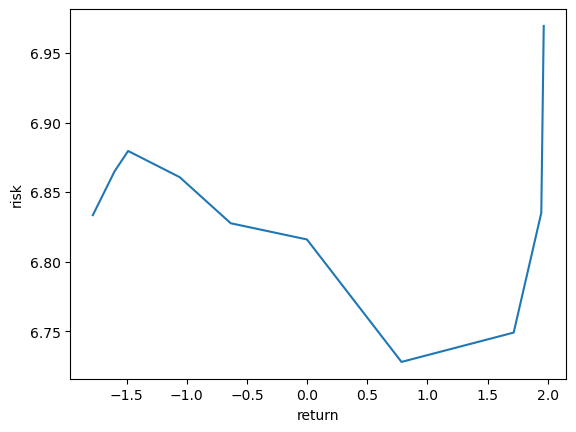

In [51]:
plt.plot(table[:,0],table[:,1])
plt.xlabel("return")
plt.ylabel("risk")